# 星巴克客户人口特征统计预测消费行为激励源：随机森林分类器的运用

## 1 背景介绍

通过分析用户行为与特征来决策商业战略已成为快消行业巨头们的标准动作，一套合理的预测模型可以为企业带来巨大的营收。本毕业设计致力于通过分析星巴克的客户行为与客户社会特征的关联性，提高锁定目标客户的精度、扩大潜在客户的群体并降低成本。因涉及多特征下的复杂分类问题，故本项目采用搭建机器学习模型的方式来根据客户特征数据、客户与推送信息的交互和消费记录来预测潜在顾客是否会对特定推送做出反应。

## 2 数据集

### 2.1 数据描述

这个数据集是一些模拟 Starbucks rewards 移动 app 上用户行为的数据。每隔几天，星巴克会向 app 的用户发送一些推送。这个推送可能仅仅是一条饮品的广告或者是折扣券或 BOGO（买一送一）。一些顾客可能一连几周都收不到任何推送。 请注意这个数据集是从星巴克 app 的真实数据简化而，模拟器仅产生了一种饮品，而实际上星巴克的饮品有几十种。

每种推送都有有效期。例如，买一送一（BOGO）优惠券推送的有效期可能只有 5 天。如果一条推送的有效期是 7 天，无论消息类型是否涉及实际金额奖励，我们都认为该顾客在这 7 天都可能受到这条推送的影响。数据集中还包含 app 上支付的交易信息，交易信息包括购买时间和购买支付的金额。交易信息还包括该顾客收到的推送种类和数量以及看了该推送的时间。顾客做出了购买行为也会产生一条记录。需要注意的是，顾客可能购买了商品，但没有收到或者没有看推送。

### 2.2 数据结构

一共有三个数据文件：

* portfolio.json – 包括推送的 id 和每个推送的元数据（持续时间、种类等等）
* profile.json – 每个顾客的人口统计数据
* transcript.json – 交易、收到的推送、查看的推送和完成的推送的记录

**portfolio.json**
* id (string) – 推送的id
* offer_type (string) – 推送的种类，例如 BOGO、打折（discount）、信息（informational）
* difficulty (int) – 满足推送的要求所需的最少花费
* reward (int) – 满足推送的要求后给与的优惠
* duration (int) – 推送持续的时间，单位是天
* channels (字符串列表)

**profile.json**
* age (int) – 顾客的年龄 
* became_member_on (int) – 该顾客第一次注册app的时间
* gender (str) – 顾客的性别（注意除了表示男性的 M 和表示女性的 F 之外，还有表示其他的 O）
* id (str) – 顾客id
* income (float) – 顾客的收入

**transcript.json**
* event (str) – 记录的描述（比如交易记录、推送已收到、推送已阅）
* person (str) – 顾客id
* time (int) – 单位是小时，测试开始时计时。该数据从时间点 t=0 开始
* value - (dict of strings) – 推送的id 或者交易的数额

### 2.3 训练集清洗策略

<img src="mind.jpg"/>


如图所示，包含在transcript.json中的用户行为可以可以根据推送状态分位以上几种。其中接收到推送且在时限内产生消费的被定义为目标客户（target customer），是本项目作为模型训练集的客户群体；而没有任何激励就有购买记录的被称为韭菜客户，这类客户将在训练集中被标注为不需任何推送就能产生消费的群体。

## 3 实验步骤

### 3.1 数据导入

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='frame', lines=True)
profile = pd.read_json('data/profile.json', orient='frame', lines=True)
transcript = pd.read_json('data/transcript.json', orient='frame', lines=True)

### 3.2 数据分析
旨在报告有关问题的特征和计算统计量，讨论了有关数据集的特征和计算统计量，并且完整描述输⼊数据。明确了所⽤数据或输⼊的异常或特点，并构建数据可视化来更好地展⽰数据探索性分析时的发现。
#### 3.2.1 portfolio

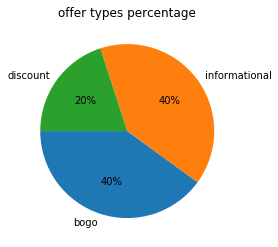

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# portfolio exploration：offer types
df_por_stat=portfolio.groupby('offer_type').count()
fig=plt.figure()
labels=portfolio.offer_type.unique().tolist()
values=df_por_stat['id'].tolist()
plt.pie(values,labels=labels,startangle=180,shadow=False,autopct='%1.0f%%')
plt.title('offer types percentage')
plt.show()
portfolio

#### 3.2.2 profile

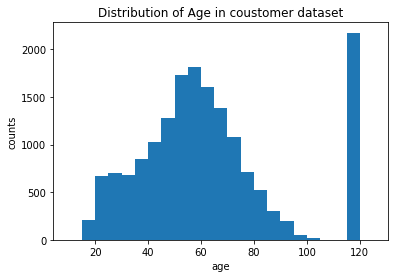

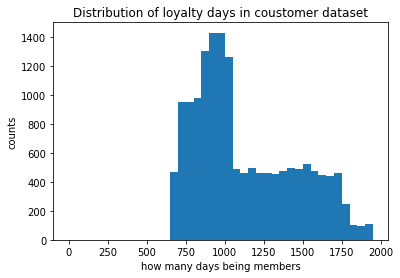

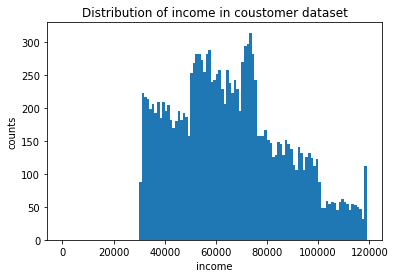

,age,became_member_on,income,loyalty_day
count,17000.0,17000.0,14825.0,17000.0
mean,62.5,20167034.2,65405.0,1193.4
std,26.7,11677.5,21598.3,411.2
min,18.0,20130729.0,30000.0,676.0
25%,45.0,20160526.0,49000.0,884.0
50%,58.0,20170802.0,64000.0,1034.0
75%,73.0,20171230.0,80000.0,1467.0
max,118.0,20180726.0,120000.0,2499.0


In [3]:
#profile exploration
profile.rename(columns={'id':'person'},inplace=True)#修改id：person，为了作为主键和transcript对应

#基于'became_member_on'计算 loyalty_day'：到今天‘2020/06/01’为止成为member的天数
start_date=datetime.strptime('2020/06/01', '%Y/%m/%d')
def str_list(x):
    b=str(x[0])+str(x[1])+str(x[2])+str(x[3])+'/'+str(x[4])+str(x[5])+'/'+str(x[6])+str(x[7])
    return b
profile['loyalty_day']=profile['became_member_on'].apply(lambda x: str_list('a'.join(str(x)).split('a'))).apply(lambda x: str(start_date-datetime.strptime(x,'%Y/%m/%d')).split(' ')[0])
profile['loyalty_day']=profile['loyalty_day'].apply(lambda x:int(x))

#年龄分布图
y=profile.age.tolist()
fig=plt.figure()
ax=fig.add_subplot()
ax.hist(y,bins=np.arange(10,130,5))
plt.xlabel('age')
plt.ylabel('counts')
plt.title('Distribution of Age in coustomer dataset')
#忠实度（成为member天数）分布图
fig1=plt.figure()
y1=profile.loyalty_day.tolist()
ax1=fig1.add_subplot()
ax1.hist(y1,bins=np.arange(0,2000,50))
plt.xlabel('how many days being members')
plt.ylabel('counts')
plt.title('Distribution of loyalty days in coustomer dataset')
plt.show()
#收入分布图
fig2=plt.figure()
y2=profile.income.tolist()
ax2=fig2.add_subplot()
ax2.hist(y2,bins=np.arange(0,120000,1000))
plt.xlabel('income')
plt.ylabel('counts')
plt.title('Distribution of income in coustomer dataset')
plt.show()
#综合统计用户特征
format = lambda x:'%.1f' % x
profile.describe().applymap(format)

基于分布图和统计表可以发现，有超过2000个用户年龄大于110岁，以下为进一步精确信息：

In [4]:
print('profile中用户信息没有重复：{}'.format(profile.shape[0]==len(profile.person.unique())))
print('总共有 {} 人登记年龄超过110岁'.format(len(np.where(profile['age']>110)[0])))

profile中用户信息没有重复：True
总共有 2175 人登记年龄超过110岁


因为年龄也会作为本项目的重要训练特征，所以这里删除这2175人的记录：

In [5]:
profile['age_error']=np.where(profile['age']>110,np.nan,1)
profile=profile.dropna(axis=0)

#### 3.2.3 transcript

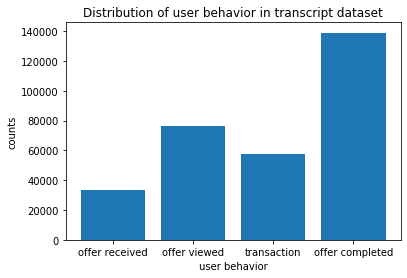

In [6]:
#plot the distribution of offers in datasets.
df_tg=transcript.groupby('event')[['person']].count()
x=transcript.event.unique().tolist()
y=df_tg.person.tolist()
fig3=plt.figure()
ax3=plt.bar(x,y)
plt.xlabel('user behavior')
plt.ylabel('counts')
plt.title('Distribution of user behavior in transcript dataset')
plt.show()

### 3.3 训练数据清洗
#### 3.3.1 Target User 数据预处理
清洗收到推送、在有效期内看了、且在有效期内消费了的用户群数据

In [7]:
#合并portfolio和transcript生成新表viewed_merge，筛选已读用户
viewed_event=transcript[transcript['event']=='offer viewed']
viewed_event['id']=viewed_event[viewed_event['event']=='offer viewed']['value'].apply(lambda x: str(list(x.values())[0]))
viewed_merge=pd.merge(portfolio,viewed_event,how='right',on='id')
viewed_person=viewed_merge[['person']]

#筛选产生消费的事件与已读事件合并为新表，保留已读且消费的客户数据
buy_event=transcript[transcript['event']=='transaction']
person_view_buy=pd.merge(viewed_merge,buy_event,how='outer',on='person')
person_view_buy=person_view_buy.dropna()

#筛选出消费行为在已读行为之后的客户数据
person_view_buy['valid_time']=np.where(person_view_buy['time_x']<person_view_buy['time_y'],1,np.nan)
person_view_buy=person_view_buy.dropna()

#筛选出有效期限内产生消费的客户数
person_view_buy['see_intime_buy1']=np.where(person_view_buy['duration']*24+person_view_buy['time_x']>person_view_buy['time_y'],1,np.nan)
person_view_buy=person_view_buy.dropna()
person_view_buy['see_intime_buy2']=np.where(person_view_buy['time_x']<person_view_buy['time_y'],1,np.nan)
person_view_buy=person_view_buy.dropna()

#整理消费数据，提取字典数值
person_view_buy['amount']=person_view_buy['value_y'].apply(lambda x: str(list(x.values())[0]))
person_view_buy=person_view_buy.drop(['value_x','value_y'],axis=1)

/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reward,channels,difficulty,duration,offer_type,id,person,event_x,time_x,event_y,time_y,valid_time,see_intime_buy1,see_intime_buy2,amount
1,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,transaction,6.0,1.0,1.0,1.0,1.44
2,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,transaction,12.0,1.0,1.0,1.0,4.5600000000000005
3,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,transaction,84.0,1.0,1.0,1.0,1.53
4,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,transaction,90.0,1.0,1.0,1.0,0.5
5,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,transaction,102.0,1.0,1.0,1.0,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495059,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,7285ee7e1e824b4c9914f3245bb4839c,offer viewed,618.0,transaction,684.0,1.0,1.0,1.0,1.56
495063,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,06ed8e3c641e4e8e803f336e5b20ddd7,offer viewed,630.0,transaction,648.0,1.0,1.0,1.0,33.77
495064,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,06ed8e3c641e4e8e803f336e5b20ddd7,offer viewed,630.0,transaction,690.0,1.0,1.0,1.0,34.54
495067,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,015ef929e016415098eeae8ce59da721,offer viewed,630.0,transaction,708.0,1.0,1.0,1.0,5.1


#### 3.3.2 韭菜客户数据预处理
清洗没收到推送or没被推送、且消费了的用户群数据

In [8]:
received_event=transcript[transcript['event']=='offer received']
buy_event=transcript[transcript['event']=='transaction']
viewed_event=transcript[transcript['event']=='offer viewed']
com_event=transcript[transcript['event']=='offer completed']

#没收到推送却购买：
no_tw_buy=buy_event[~buy_event.person.isin(received_event.person)]
#收到推送没看却购买(无此情况)
a=received_event[~received_event.person.isin(viewed_event.person)]
tw_nosee_buy=a[a.person.isin(buy_event)]
#清洗消费金额数据
no_tw_buy['amount']=no_tw_buy['value'].apply(lambda x: str(list(x.values())[0]))

/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,person,event,value,time,amount
16379,eb540099db834cf59001f83a4561aef3,transaction,{'amount': 4.74},6,4.74
22092,12ede229379747bd8d74ccdc20097ca3,transaction,{'amount': 16.62},18,16.62
69477,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,{'amount': 0.65},174,0.65
87239,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,{'amount': 1.9100000000000001},222,1.9100000000000001
106812,ae8111e7e8cd4b60a8d35c42c1110555,transaction,{'amount': 17.51},306,17.51
108268,eb540099db834cf59001f83a4561aef3,transaction,{'amount': 5.09},318,5.09
109340,3a4874d8f0ef42b9a1b72294902afea9,transaction,{'amount': 22.75},324,22.75
109815,12ede229379747bd8d74ccdc20097ca3,transaction,{'amount': 27.6},324,27.6
110707,ae8111e7e8cd4b60a8d35c42c1110555,transaction,{'amount': 28.7},330,28.7
142347,3a4874d8f0ef42b9a1b72294902afea9,transaction,{'amount': 27.2},378,27.2


#### 3.3.3 训练集数据清洗

In [86]:
#creating training data framework
df_target_person=person_view_buy[['person','offer_type','amount']]
df_jiucai_person=no_tw_buy[['person','amount']]
profile.rename(columns={'id':'person'},inplace=True)
df_training_frame=pd.merge(df_target_person,profile,how='left',on='person')
df_training_frame1=pd.merge(df_jiucai_person,profile,how='left',on='person')

#creating dummy for offertype and gender
df_training_dummy=pd.get_dummies(df_training_frame, dummy_na=False, 
               columns=['offer_type','gender'], drop_first=False).drop(['gender_O','age_error'],axis=1)
df_training_dummy=df_training_dummy.dropna(axis=0)
df_training_dummy1=pd.get_dummies(df_training_frame1, dummy_na=False, 
               columns=['gender'], drop_first=False).drop(['age_error'],axis=1)
df_training_dummy1=df_training_dummy1.dropna(axis=0)
df_training_dummy=pd.concat([df_training_dummy,df_training_dummy1]).fillna(0)

### 3.4 模型搭建、训练和评估

本模型旨在运用随机森林算法根据客户特征（年龄、性别、收入、加入会员的时长）来预测客户对某一种推送是否会有激励反应（bogo、discount、informational）。本模型通过sklearn.metrics.classification_report打印模型评估报告，对本课题来说，准确预测target的‘1’是充要任务（预测100个客户对推送感兴趣，其中有80个真实产生消费是关键任务，毕竟预测错了也只是多发了推送而已，仅产生边际损失），而对‘0’的准确预测并不是特别重要（就目前的数据量也无法完整地筛选出所有的目标客户）。换句话来说，在本次试验中precision是比recall重要很多模型评估参数，故本模型以precision分数作为评价标准。

#### 3.4.1 随机森林分类器

首先，本模块尝试先实现算法功能并得到evaluation report，观察随机森林基础设置下（n_estimators=500,n_jobs=2,oob_score=True,min_samples_split=50,class_weight='balanced'）的分类情况。

In [98]:
#分类器：对有一系列特征的客户推送什么最好
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

#划分训练集与测试集，测试集的比例为5%（因为仅看到informational推送就产生消费的客户群远少于bogo与discount,所以多分布一些训练集）
X=df_training_dummy[['age','income','gender_F','gender_M','loyalty_day']]
Y=df_training_dummy[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.05)

#训练模型
model=RandomForestClassifier(n_estimators=500,n_jobs=2,oob_score=True,
                             min_samples_split=50,class_weight='balanced')

model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
target_names = list(Y_test.columns)
df_Y_pred=pd.DataFrame(Y_pred,columns=list(Y_test.columns))

#分析报告
print(classification_report(Y_test, Y_pred, target_names=list(Y_test.columns)))

                          precision    recall  f1-score   support

         offer_type_bogo       0.70      0.25      0.37      2283
     offer_type_discount       0.82      0.20      0.32      2735
offer_type_informational       0.23      0.45      0.30       510

               micro avg       0.54      0.24      0.34      5528
               macro avg       0.59      0.30      0.33      5528
            weighted avg       0.72      0.24      0.34      5528
             samples avg       0.24      0.24      0.24      5528



/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



#### 3.4.2 模型结果讨论

可以看到效果一般，RandomForestClassifier的分类器对bogo和discount的预测准确度勉强合格（bogo=0.7；discount=0.82），可能归结于训练集中有购买倾向的客人受bogo和discount的正向影响较大。同时，结果发现模型对informational的预测精度十分差（precision=0.23），但recall率却较高，说明对informational的positive case预测准确率还是可以的。informational预测精度极低的原因可能有两点：1）informational相应的训练集较少；2）无法通过现有客户特征模拟出看到消息类推送就会发生购买行为的特征模型。

#### 3.4.3 其他变量控制尝试：训练集归一化

为了排除其他因素影响，所以尝试将训练数据进行归一化：

In [99]:
def regularit(df):
    newDataFrame = pd.DataFrame(index=df.index)
    columns = df.columns.tolist()
    for c in columns:
        d = df[c]
        MAX = d.max()
        MIN = d.min()
        newDataFrame[c] = ((d - MIN) / (MAX - MIN)).tolist()
    return newDataFrame
X=regularit(df_training_dummy[['age','income','gender_F','gender_M','loyalty_day']])
Y=df_training_dummy[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.05)

#训练模型
model=RandomForestClassifier(n_estimators=500,n_jobs=2,oob_score=True,
                             min_samples_split=50,class_weight='balanced')
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
target_names = list(Y_test.columns)
df_Y_pred=pd.DataFrame(Y_pred,columns=list(Y_test.columns))

#分析报告
print(classification_report(Y_test, Y_pred, target_names=list(Y_test.columns)))

                          precision    recall  f1-score   support

         offer_type_bogo       0.71      0.24      0.36      2321
     offer_type_discount       0.79      0.20      0.32      2726
offer_type_informational       0.20      0.45      0.27       480

               micro avg       0.51      0.24      0.33      5527
               macro avg       0.56      0.30      0.32      5527
            weighted avg       0.70      0.24      0.33      5527
             samples avg       0.24      0.24      0.24      5527



/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/huatongyan/anaconda3/envs/pipework/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


可以发现训练精度不佳且精度略微下降，故不考虑数据归一化与否对本实验的影响。

### 3.5 结论

#### 3.5.1 反思

本项目利用随机森林模型，把目标客户的年龄、收入、性别和成为member的日期天数作为训练集特征，构建了机器学习模型去预测某一客户对哪一种推送会产生消费反应，从而定向地向这一类客户推送消息。由于训练数据有限、计算资源有限、模型对不同推送消息的预测精度有待提高。本项目十分贴近真实business analysis 的场景，其中消费劵有期限和消费者是否看到消费劵产生消费行为的数据清洗让我觉得十分有挑战性，也是让我最获益匪浅的地方。

#### 3.5.2 改进
##### 本模块由于电脑算力有限暂不运行，仅作为模型调优的一个可能解置之于此：

from sklearn.model_selection import GridSearchCV

estimator=RandomForestClassifier(n_jobs=2,oob_score=True)
parameters = {'n_estimators': [100, 200,350,500],'min_samples_split': [2,.01,.1,.5,.8],
             'class_weight':['balanced',None],'max_features':['auto','log2',None],
              'max_leaf_nodes':[None,10,50,100,200]}

model = GridSearchCV(estimator, param_grid=parameters,return_train_score=True,scoring='average_precision')
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
target_names = list(Y_test.columns)
df_Y_pred=pd.DataFrame(Y_pred,columns=list(Y_test.columns))

#分析报告
print(classification_report(Y_test, Y_pred, target_names=list(Y_test.columns)))